## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import shutil
import tempfile
import time
import numpy as np
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import HoVerNetLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import HoVerNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ComputeHoVerMaps,
)
from monai.utils import set_determinism, convert_to_tensor
from monai.utils.enums import HoVerNetBranch

import torch

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.0.0+93.gfefdead6.dirty
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+d321be6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: fefdead62f906512030cf31e38f8945010d53cf0
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.21.3
mlflow version: 1.28.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

## Download dataset

In [5]:
data_dir = os.path.join(root_dir, "CoNSeP")

train_images = sorted(
    glob.glob(os.path.join(data_dir, "Train/Images", "*.png")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "Train/Labels", "*.mat")))
train_overlays = sorted(
    glob.glob(os.path.join(data_dir, "Train/Overlay", "*.png")))
data_dicts = [
    {"image": image_name, "label": label_name, "overlay": overlay_name}
    for image_name, label_name, overlay_name in zip(train_images, train_labels, train_overlays)
]
train_files, val_files = data_dicts[:5], data_dicts[-5:]

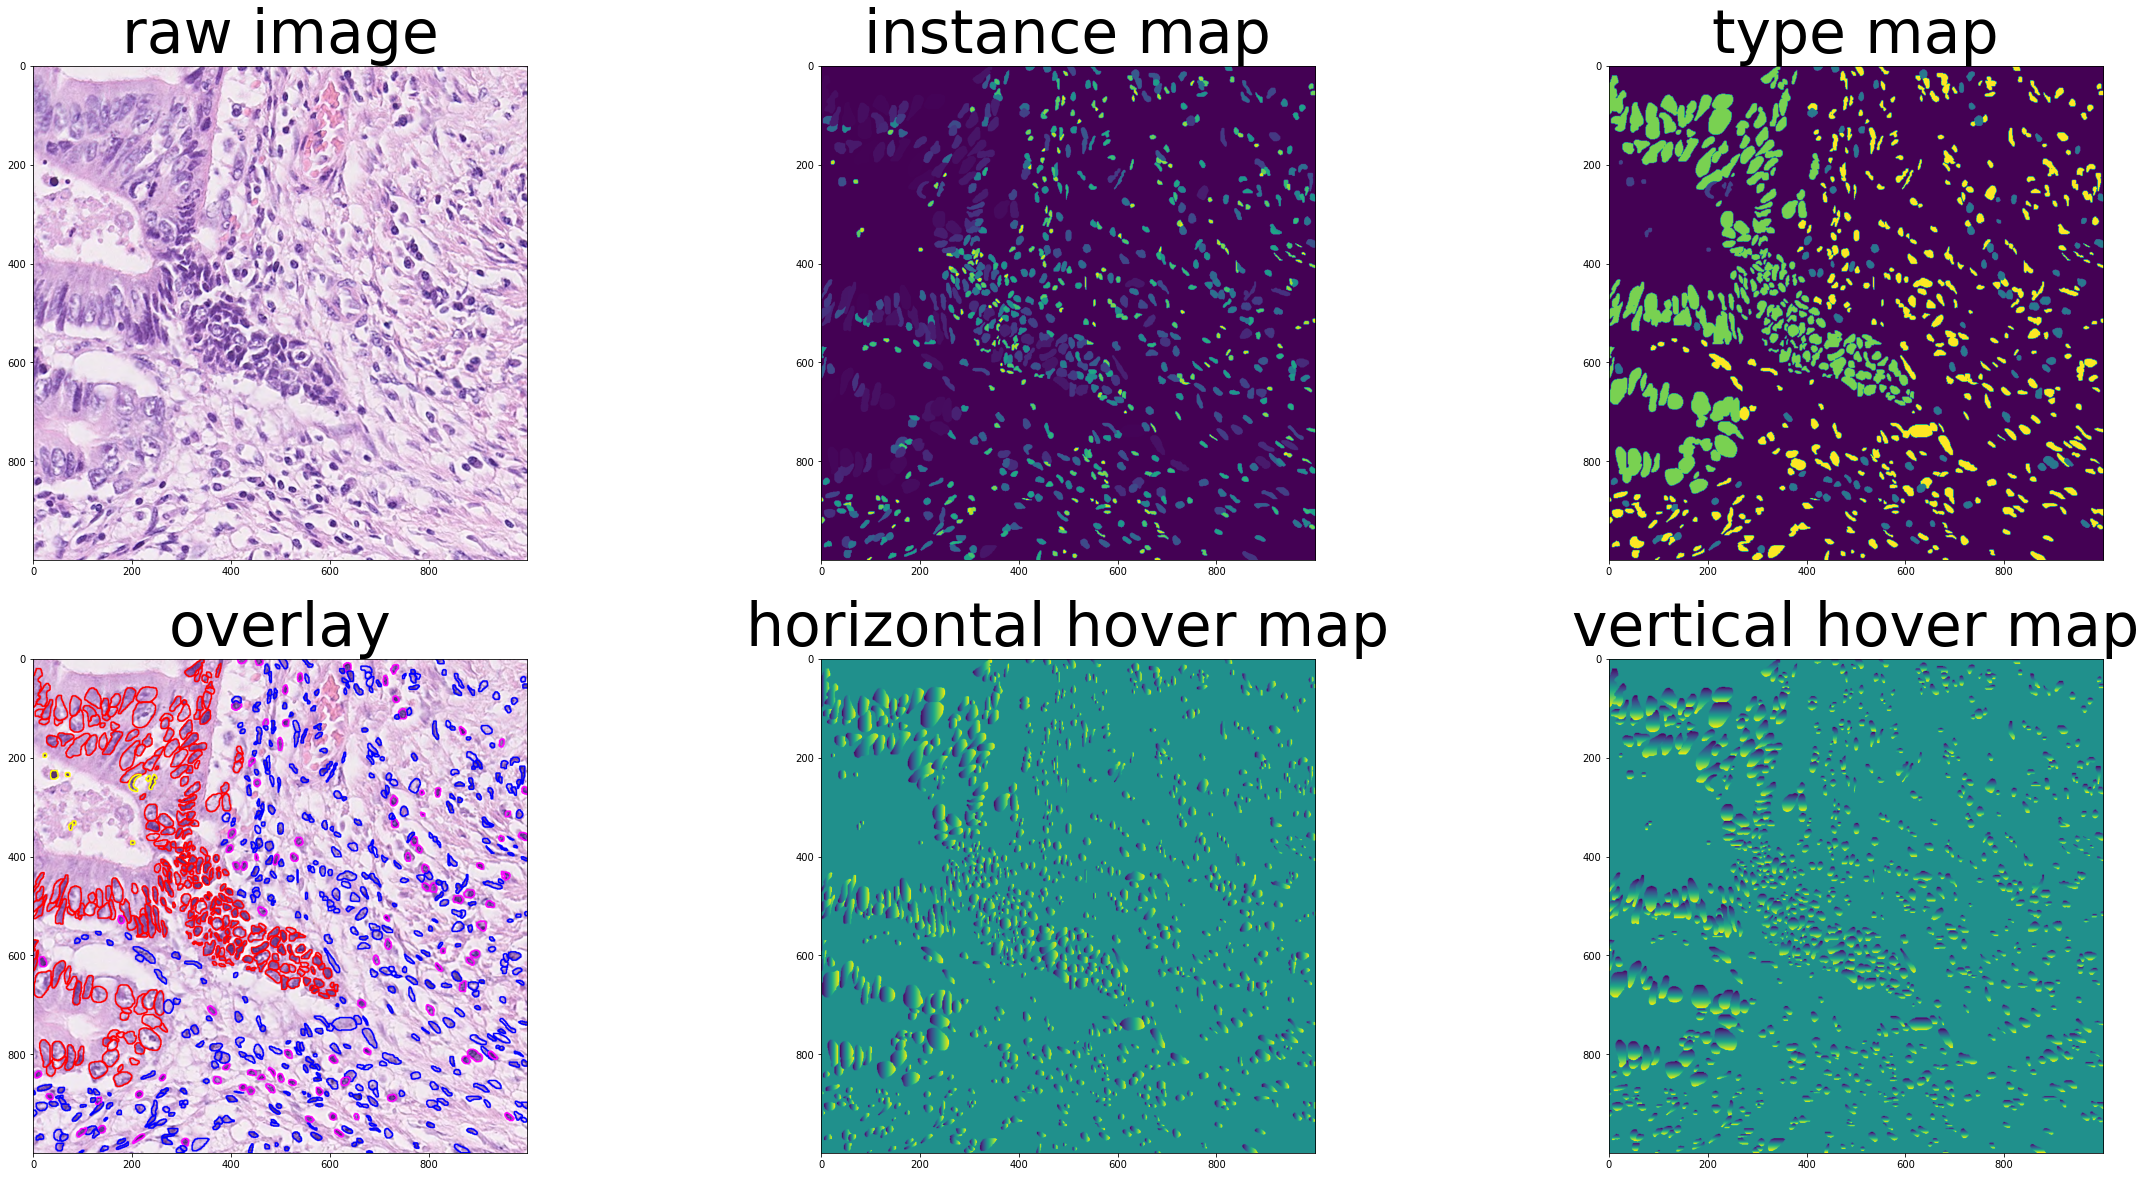

instance map shape (1000, 1000)
number of instances 850
number of type predictions 4
overlay shape (1000, 1000, 3)


In [6]:
import scipy.io as sio
import numpy as np
from monai.transforms import LoadImage, ComputeHoVerMaps
image = LoadImage(image_only=True)(train_files[0]['image'])
label = sio.loadmat(train_files[0]['label'])
overlay = LoadImage(image_only=True)(train_files[0]['overlay'])

inst_map = label['inst_map']
type_map = label['type_map']
inst_type = label['inst_type']
inst_centroid = label['inst_centroid']

hovermaps = ComputeHoVerMaps()(inst_map[None].astype(np.uint32))

# plot the original image, along with the instance map and the overlay
fig, ax = plt.subplots(2,3,figsize = (40,20))
ax[0, 0].imshow(image.astype(np.uint8).transpose(1,0,2))
ax[0, 1].imshow(inst_map)
ax[0, 2].imshow(type_map)
ax[1, 0].imshow(overlay.astype(np.uint8).transpose(1,0,2))
ax[1, 1].imshow(hovermaps[0, ...])
ax[1, 2].imshow(hovermaps[1, ...])
ax[0, 0].set_title('raw image', fontsize=60)
ax[0, 1].set_title('instance map', fontsize=60)
ax[0, 2].set_title('type map', fontsize=60)
ax[1, 0].set_title('overlay', fontsize=60)
ax[1, 1].set_title('horizontal hover map', fontsize=60)
ax[1, 2].set_title('vertical hover map', fontsize=60)
plt.show()

# double check the number of instances is the same as the number of type predictions
print('instance map shape', inst_map.shape)
print('number of instances', len(np.unique(inst_map)[1:].tolist()))
print('number of type predictions', len(np.unique(inst_type)))
print('overlay shape', overlay.shape)


# Process Json File

In [7]:
from pathlib import Path
import nibabel as nib
import json
compute_hover_maps = ComputeHoVerMaps()

train_list = []
for _train_file in train_files:
    case = {}
    image = _train_file['image']
    label = sio.loadmat(_train_file['label'])
    instance_map = label['inst_map']
    
    type_map = label['type_map']
    hover_map = compute_hover_maps(instance_map[None].astype(np.uint32))
    hover_map_path = Path(_train_file['image']).parent/f"hover_map_{Path(_train_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(np.array(hover_map.squeeze()), np.eye(4)), hover_map_path)
    type_map_path = Path(_train_file['image']).parent/f"type_map_{Path(_train_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(type_map, np.eye(4)), type_map_path)
    inst_map_path = Path(_train_file['image']).parent/f"inst_map_{Path(_train_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(instance_map, np.eye(4)), inst_map_path)
    instance_map[instance_map>0] = 1
    label_path = Path(_train_file['image']).parent/f"label_{Path(_train_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(instance_map, np.eye(4)), label_path)
    case['image'] = image
    case['hover'] = str(hover_map_path)
    case['type_map'] = str(type_map_path)
    case['inst_map'] = str(inst_map_path)
    case['label'] = str(label_path)
    train_list.append(case)

test_list = []
for _test_file in val_files:
    case = {}
    image = _test_file['image']
    label = sio.loadmat(_test_file['label'])
    instance_map = label['inst_map']
    type_map = label['type_map']
    hover_map = compute_hover_maps(instance_map[None].astype(np.uint32))
    hover_map_path = Path(_test_file['image']).parent/f"hover_map_{Path(_test_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(np.array(hover_map), np.eye(4)), hover_map_path)
    type_map_path = Path(_test_file['image']).parent/f"type_map_{Path(_test_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(type_map, np.eye(4)), type_map_path)
    inst_map_path = Path(_test_file['image']).parent/f"inst_map_{Path(_test_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(instance_map, np.eye(4)), inst_map_path)
    instance_map[instance_map>0] = 1
    label_path = Path(_test_file['image']).parent/f"label_{Path(_test_file['image']).name.split('_')[1][:-4]}.nii.gz"
    nib.save(nib.Nifti1Image(instance_map, np.eye(4)), label_path)
    print(np.array(hover_map).shape, type_map[None].shape)
    case['image'] = image
    case['hover'] = str(hover_map_path)
    case['type_map'] = str(type_map_path)
    case['label'] = str(label_path)
    case['inst_map'] = str(inst_map_path)
    test_list.append(case)

with open(Path(root_dir)/'CoNSeP/Train/train.json', 'w') as f:
    json.dump(train_list, f, indent = 2)
with open(Path(root_dir)/'CoNSeP/Train/test.json', 'w') as f:
    json.dump(test_list, f, indent = 2)

(2, 1000, 1000) (1, 1000, 1000)
(2, 1000, 1000) (1, 1000, 1000)
(2, 1000, 1000) (1, 1000, 1000)
(2, 1000, 1000) (1, 1000, 1000)
(2, 1000, 1000) (1, 1000, 1000)


In [8]:
import json
from pathlib import Path
with open (Path(root_dir)/'CoNSeP/Train/train.json', 'r') as f:
    train_list = json.load(f)
with open (Path(root_dir)/'CoNSeP/Train/test.json', 'r') as f:
    test_list = json.load(f)

In [9]:
def cropping_center(x, crop_shape, batch=False):
    """Crop an input image at the centre.
    Args:
        x: input array
        crop_shape: dimensions of cropped array
    
    Returns:
        x: cropped array
    
    """
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:, h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[2] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[3] - crop_shape[1]) * 0.5)
        x = x[..., h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    return x

In [10]:
a = LoadImaged(keys=["image", "inst_map","label", "hover", "type_map"], image_only=True)(test_list[0])
b = EnsureChannelFirstd(keys=["inst_map", "type_map"])(a)
print(b['type_map'].shape)

(1, 1000, 1000)


In [11]:
from monai.transforms import (
    LoadImaged, 
    RandGridPatchd, 
    Lambdad,
    ToTensord, 
    EnsureChannelFirstd, 
    GridSplitd, 
    Transposed, 
    RandCropByPosNegLabeld, 
    ScaleIntensityRanged,
    CastToTyped,
    AsDiscreted,
)
num_samples = 1
tile_size = (256, 256)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


def process_label(label):
    label[(label == 3) | (label == 4)] = 3
    label[(label == 5) | (label == 6) | (label == 7)] = 4
    return label

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "inst_map","label", "hover", "type_map"], image_only=True),
        EnsureChannelFirstd(keys=['image', "inst_map", "label", 'type_map']),
        EnsureChannelFirstd(keys=['hover'], channel_dim=0),
        Transposed(keys="image", indices=(0, 2, 1)),
        RandCropByPosNegLabeld(keys=["image", "inst_map", "label", "hover", "type_map"], label_key="label", spatial_size=tile_size, pos=1, neg=0, num_samples=num_samples),
        ScaleIntensityRanged(keys="image", a_min=0.0, a_max=255.0, b_min=0, b_max=1.0),
        Lambdad(keys="type_map", func=lambda x: process_label(x)),
        Lambdad(keys=["inst_map", "label", "hover", "type_map"], func=lambda x: cropping_center(x, crop_shape=(164, 164))),
        AsDiscreted(keys=['type_map', 'label'], to_onehot=[5, 2]),
        CastToTyped(keys=["image", "inst_map", "label", "hover", "type_map"], dtype=torch.float32),
        ToTensord(keys=["image", "inst_map", "label", "hover", "type_map"]),
#         RandFlipd(keys="image", prob=cfg["prob"], spatial_axis=-1),
#         RandRotate90d(keys="image", prob=cfg["prob"]),
#         CastToTyped(keys="image", dtype=np.float32),
#         ScaleIntensityRanged(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
#         ToTensord(keys="image"),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "inst_map","label", "hover", "type_map"], image_only=True),
        EnsureChannelFirstd(keys=['image', "inst_map", "label", 'type_map']),
        EnsureChannelFirstd(keys=['hover'], channel_dim=0),
        Transposed(keys="image", indices=(0, 2, 1)),
        RandCropByPosNegLabeld(keys=["image", "inst_map", "label", "hover", "type_map"], label_key="label", spatial_size=tile_size, pos=1, neg=0, num_samples=num_samples),
        ScaleIntensityRanged(keys="image", a_min=0.0, a_max=255.0, b_min=0, b_max=1.0),
        Lambdad(keys="type_map", func=lambda x: process_label(x)),
        Lambdad(keys=["inst_map", "label", "hover", "type_map"], func=lambda x: cropping_center(x, crop_shape=(164, 164))),
        AsDiscreted(keys=['type_map', 'label'], to_onehot=[5, 2]),
        CastToTyped(keys=["image", "inst_map", "label", "hover", "type_map"], dtype=torch.float32),
        ToTensord(keys=["image", "inst_map", "label", "hover", "type_map"]),
    ]
)


(3, 256, 256) (5, 164, 164) (2, 164, 164) (2, 164, 164) (1, 164, 164)
(3, 256, 256) (5, 164, 164) (2, 164, 164) (2, 164, 164) (1, 164, 164)
(3, 256, 256) (5, 164, 164) (2, 164, 164) (2, 164, 164) (1, 164, 164)
(3, 256, 256) (5, 164, 164) (2, 164, 164) (2, 164, 164) (1, 164, 164)
(3, 256, 256) (5, 164, 164) (2, 164, 164) (2, 164, 164) (1, 164, 164)


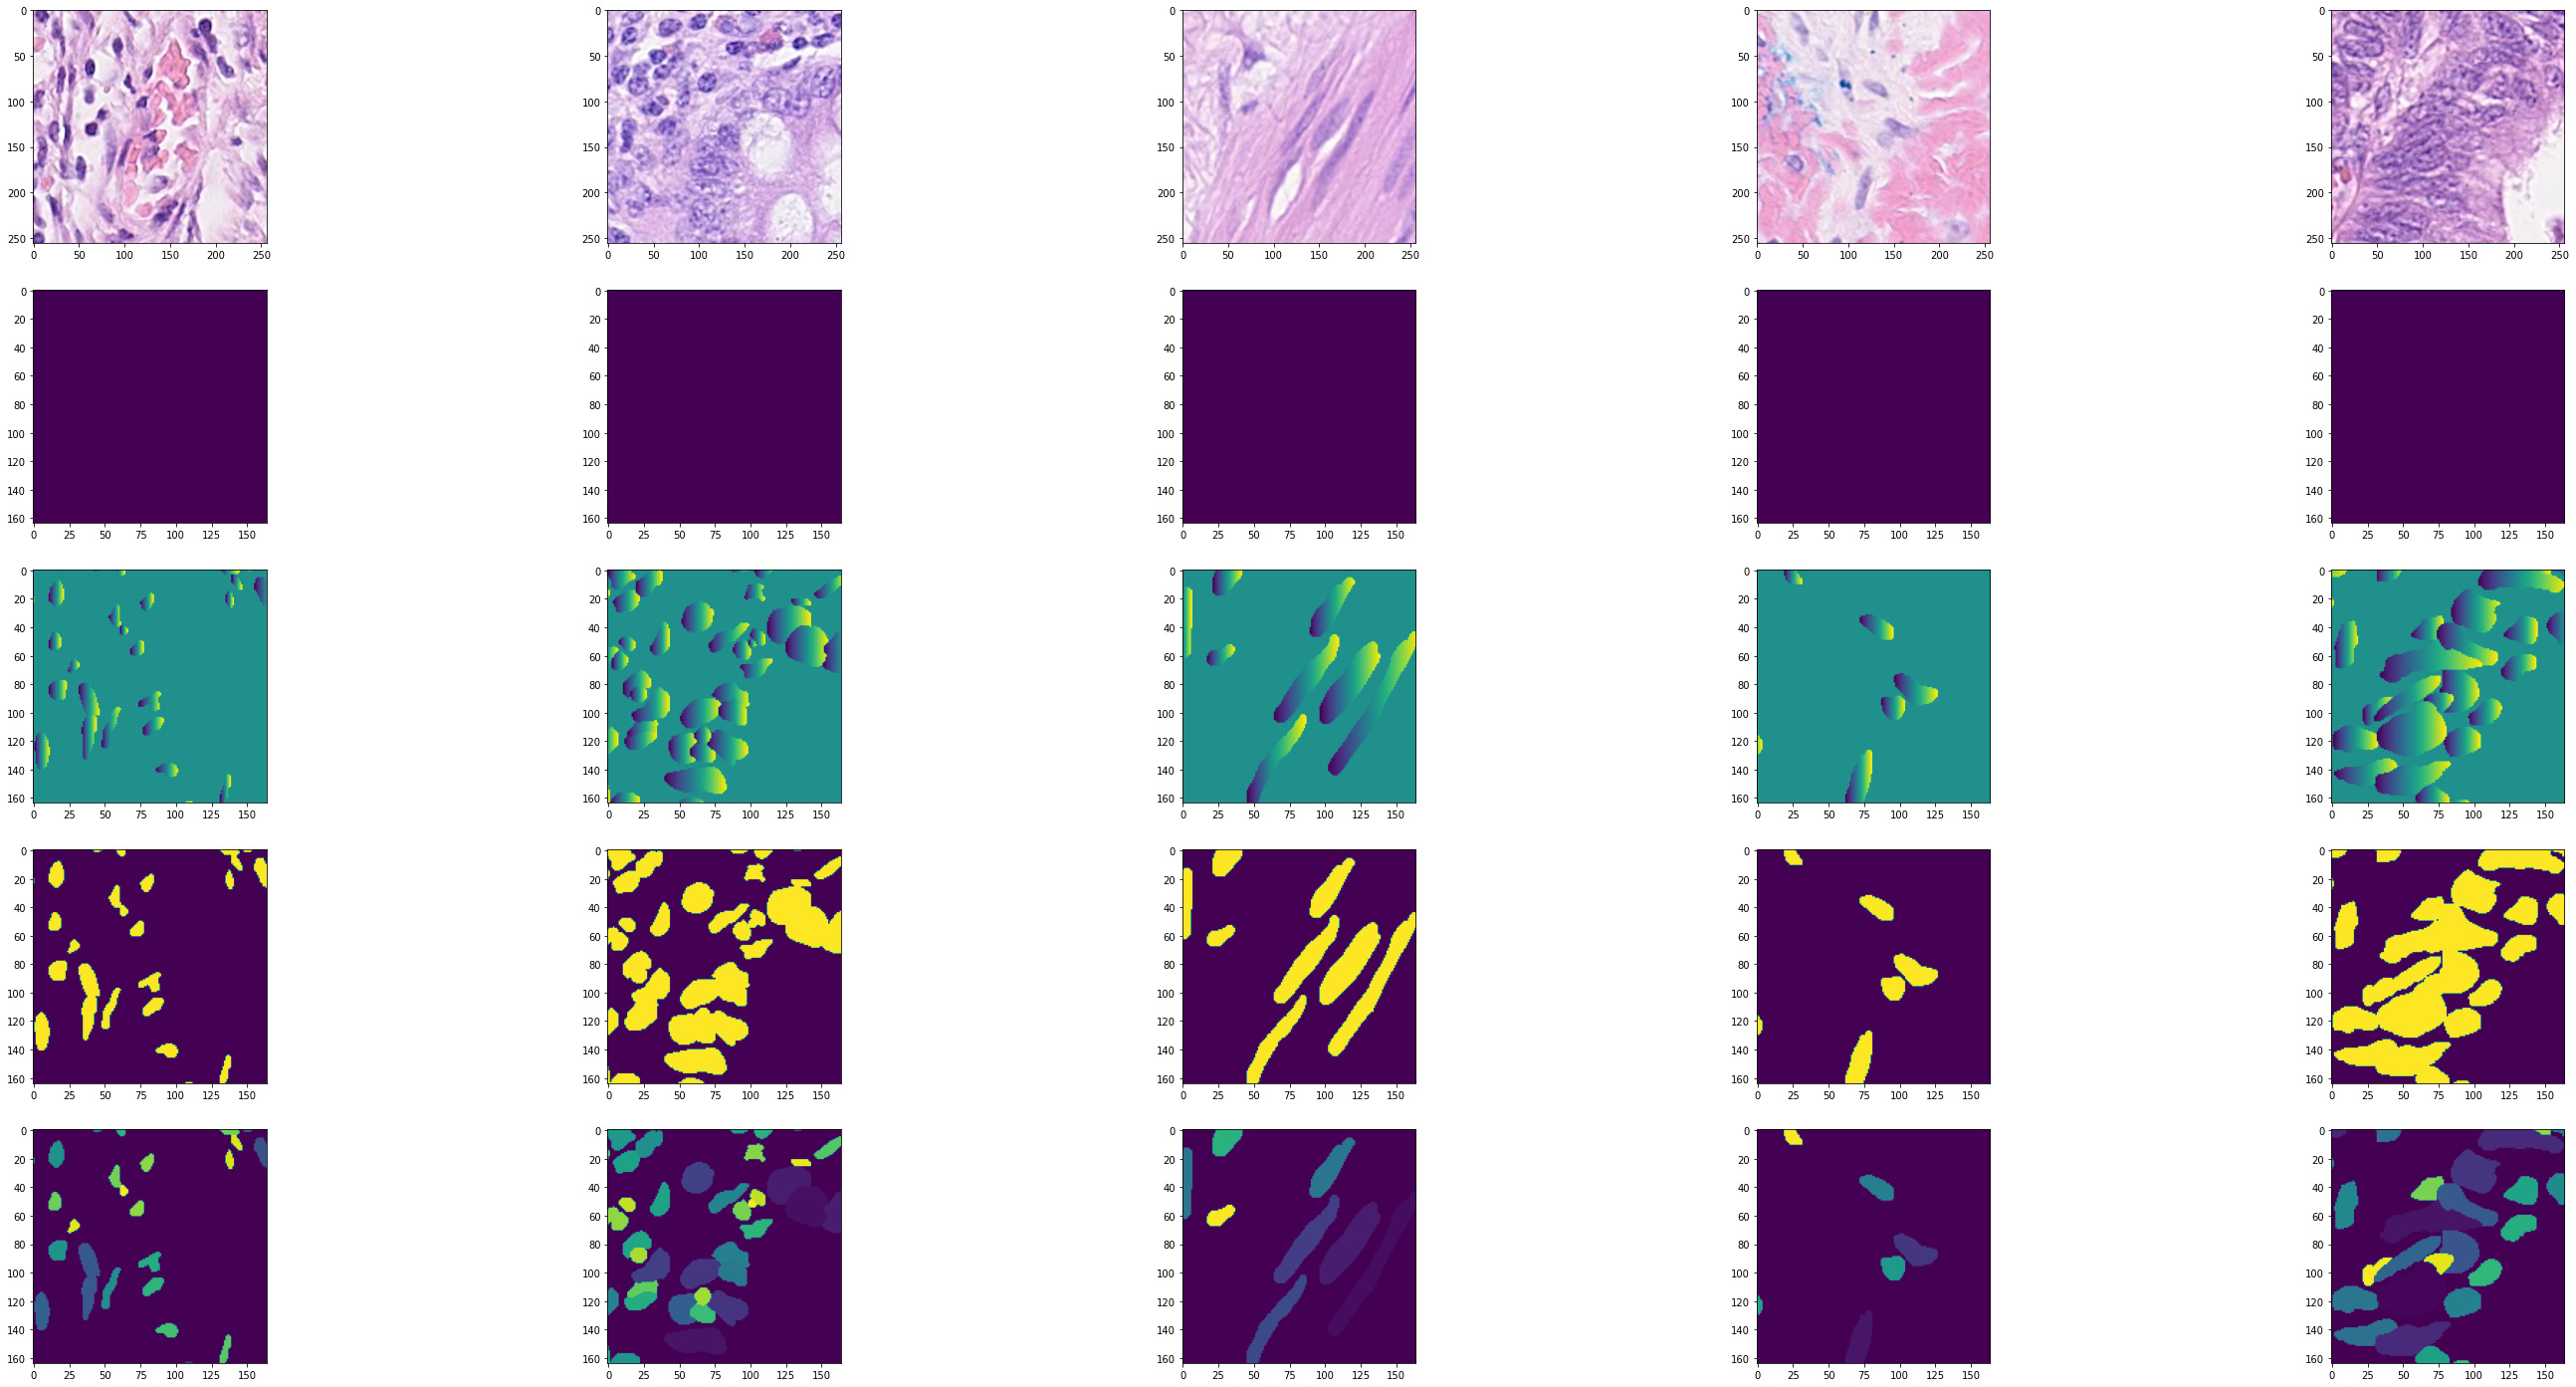

In [12]:
from monai.data import Dataset, DataLoader
train_ds = Dataset(
    data=train_list,
    transform=train_transforms,
)
valid_ds = Dataset(
    data=test_list,
    transform=val_transforms,
)

train_loader = DataLoader(
    train_ds,
    batch_size=5,
    pin_memory=True,
)
val_loader = DataLoader(
    valid_ds,
    batch_size=1,
)

fig, ax = plt.subplots(5,5,figsize = (50,25))
for _i, i in enumerate(train_ds):
    print(i[0]['image'].shape, i[0]['type_map'].shape, i[0]['hover'].shape, i[0]['label'].shape, i[0]['inst_map'].shape)
    for j in range(1):
        ax[0, _i].imshow((i[j]['image']*255).astype(np.uint8).transpose(1, 2, 0))
        ax[1, _i].imshow(i[j]['type_map'][1, ...].squeeze())
        ax[2, _i].imshow(i[j]['hover'][0, ...])
        ax[3, _i].imshow(i[j]['label'][1, ...].squeeze())
        ax[4, _i].imshow(i[j]['inst_map'].squeeze())

In [13]:
from monai.networks.nets import HoVerNet
max_epochs = 600
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = HoVerNet(
    mode="fast",
    in_channels=3,
    out_classes=5,
    act=("relu", {"inplace": True}),
    norm="batch",
    dropout_prob=0.0,
).to(device)
loss_function = HoVerNetLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


In [14]:
torch.cuda.empty_cache()

In [15]:
from typing import Callable, Dict, Hashable, Mapping, Optional

import numpy as np

from monai.config.type_definitions import DtypeLike, NdarrayOrTensor
from monai.transforms.post.array import Activations, AsDiscrete, RemoveSmallObjects, SobelGradients
from monai.transforms.transform import Transform
from monai.transforms.utils_pytorch_numpy_unification import max, maximum, min
from monai.utils import TransformBackends, convert_to_numpy, optional_import
from monai.utils.type_conversion import convert_to_dst_type
from monai.config.type_definitions import DtypeLike, KeysCollection, NdarrayOrTensor
from monai.transforms.transform import MapTransform
import scipy.ndimage as ndi
from skimage.morphology import disk
from skimage.morphology import opening
from skimage.segmentation import watershed

__all__ = ["Watershed", "GenerateMask", "GenerateProbabilityMap", "GenerateDistanceMap", "GenerateMarkers"]


class Watershed(Transform):
    """
    Use `skimage.segmentation.watershed` to get instance segmentation results from images.
    See: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed.

    Args:
        connectivity: An array with the same number of dimensions as image whose non-zero elements indicate
            neighbors for connection. Following the scipy convention, default is a one-connected array of
            the dimension of the image.
        dtype: target data content type to convert, default is np.uint8.

    """

    backend = [TransformBackends.NUMPY]

    def __init__(self, connectivity: Optional[int] = 1, dtype: DtypeLike = np.uint8) -> None:
        self.connectivity = connectivity
        self.dtype = dtype

    def __call__(  # type: ignore
        self, image: NdarrayOrTensor, mask: Optional[NdarrayOrTensor] = None, markers: Optional[NdarrayOrTensor] = None
    ) -> NdarrayOrTensor:
        """
        Args:
            image: image where the lowest value points are labeled first. Shape must be [1, H, W, [D]].
            mask: optional, the same shape as image. Only points at which mask == True will be labeled.
                If None (no mask given), it is a volume of all 1s.
            markers: optional, the same shape as image. The desired number of markers, or an array marking
                the basins with the values to be assigned in the label matrix. Zero means not a marker.
                If None (no markers given), the local minima of the image are used as markers.
        """

        image = convert_to_numpy(image)
        markers = convert_to_numpy(markers)
        mask = convert_to_numpy(mask)

        instance_seg = watershed(image, markers=markers, mask=mask, connectivity=self.connectivity)

        return convert_to_dst_type(instance_seg, image, dtype=self.dtype)[0]


class GenerateMask(Transform):
    """
    generate mask used in `watershed`. Only points at which mask == True will be labeled.

    Args:
        softmax: if True, apply a softmax function to the prediction.
        sigmoid: if True, apply a sigmoid function to the prediction.
        threshold: if not None, threshold the float values to int number 0 or 1 with specified theashold.
        remove_small_objects: whether need to remove some objects in the marker. Defaults to True.
        min_size: objects smaller than this size are removed if `remove_small_objects` is True. Defaults to 10.
        dtype: target data content type to convert, default is np.uint8.

    """

    backend = [TransformBackends.NUMPY]

    def __init__(
        self,
        softmax: bool = True,
        sigmoid: bool = False,
        threshold: Optional[float] = None,
        remove_small_objects: bool = True,
        min_size: int = 10,
        dtype: DtypeLike = np.uint8,
    ) -> None:
        if sigmoid and threshold is None:
            raise ValueError("Threshold is needed when using sigmoid activation.")

        self.dtype = dtype
        self.activations = Activations(sigmoid=sigmoid, softmax=softmax)
        self.asdiscrete = AsDiscrete(threshold=threshold, argmax=softmax)
        if remove_small_objects:
            self.remove_small_objects = RemoveSmallObjects(min_size=min_size)
        else:
            self.remove_small_objects = None  # type: ignore

    def __call__(self, prob_map: NdarrayOrTensor) -> NdarrayOrTensor:
        """
        Args:
            prob_map: probability map of segmentation, shape must be [C, H, W, [D]]
        """

        pred = self.activations(prob_map)
        pred = self.asdiscrete(pred)

        pred = convert_to_numpy(pred)
        pred = ndi.label(pred)[0]
        if self.remove_small_objects:
            pred = self.remove_small_objects(pred)
        pred[pred > 0] = 1  # type: ignore

        return convert_to_dst_type(pred, prob_map, dtype=self.dtype)[0]


class GenerateProbabilityMap(Transform):
    """
    Generate foreground probability map by hover map. The more parts of the image that cannot be identified as foreground areas,
    the larger the grey scale value. The grey value of the instance's border will be larger.

    Args:
        kernel_size: the size of the Sobel kernel. Defaults to 21.
        remove_small_objects: whether need to remove some objects in segmentation results. Defaults to True.
        min_size: objects smaller than this size are removed if `remove_small_objects` is True. Defaults to 10.
        dtype: target data content type to convert, default is np.float32.


    Raises:
        ValueError: when the `mask` shape is not [1, H, W].
        ValueError: when the `hover_map` shape is not [2, H, W].

    """

    backend = [TransformBackends.NUMPY]

    def __init__(
        self,
        kernel_size: int = 21,
        min_size: int = 10,
        remove_small_objects: bool = True,
        dtype: DtypeLike = np.float32,
    ) -> None:

        self.dtype = dtype

        self.sobel_gradient = SobelGradients(kernel_size=kernel_size)
        if remove_small_objects:
            self.remove_small_objects = RemoveSmallObjects(min_size=min_size)
        else:
            self.remove_small_objects = None  # type: ignore

    def __call__(self, mask: NdarrayOrTensor, hover_map: NdarrayOrTensor) -> NdarrayOrTensor:  # type: ignore
        """
        Args:
            mask: binarized segmentation result.  Shape must be [1, H, W].
            hover_map:  horizontal and vertical distances of nuclear pixels to their centres of mass. Shape must be [2, H, W].
                The first and second channel represent the horizontal and vertical maps respectively. For more details refer
                to papers: https://arxiv.org/abs/1812.06499.

        Return:
            Foreground probability map.

        Raises:
            ValueError: when the `hover_map` has only one value.
            ValueError: when the `sobel gradient map` has only one value.

        """
        if len(mask.shape) != 3 or len(hover_map.shape) != 3:
            raise ValueError(
                f"Suppose the mask and hover map should be with shape of [C, H, W], but got {mask.shape}, {hover_map.shape}"
            )
        if mask.shape[0] != 1:
            raise ValueError(f"Suppose the mask only has one channel, but got {mask.shape[0]}")
        if hover_map.shape[0] != 2:
            raise ValueError(f"Suppose the hover map only has two channels, but got {hover_map.shape[0]}")

        hover_h = hover_map[0:1, ...]
        hover_v = hover_map[1:2, ...]

        hover_h_min, hover_h_max = min(hover_h), max(hover_h)
        hover_v_min, hover_v_max = min(hover_v), max(hover_v)
        if (hover_h_max - hover_h_min) == 0 or (hover_v_max - hover_v_min) == 0:
            raise ValueError("Not a valid hover map, please check your input")
        hover_h = (hover_h - hover_h_min) / (hover_h_max - hover_h_min)
        hover_v = (hover_v - hover_v_min) / (hover_v_max - hover_v_min)
        sobelh = self.sobel_gradient(hover_h)[0, ...]
        sobelv = self.sobel_gradient(hover_v)[1, ...]
        sobelh_min, sobelh_max = min(sobelh), max(sobelh)
        sobelv_min, sobelv_max = min(sobelv), max(sobelv)
        if (sobelh_max - sobelh_min) == 0 or (sobelv_max - sobelv_min) == 0:
            raise ValueError("Not a valid sobel gradient map")
        sobelh = 1 - (sobelh - sobelh_min) / (sobelh_max - sobelh_min)
        sobelv = 1 - (sobelv - sobelv_min) / (sobelv_max - sobelv_min)

        # combine the h & v values using max
        overall = maximum(sobelh, sobelv)
        overall = overall - (1 - mask)
        overall[overall < 0] = 0

        return convert_to_dst_type(overall, mask, dtype=self.dtype)[0]


class GenerateDistanceMap(Transform):
    """
    Generate distance map.
    In general, the instance map is calculated from the distance to the background.
    Here, we use 1 - "foreground probability map" to generate the distance map.
    Nuclei values form mountains so inverse to get basins.

    Args:
        smooth_fn: execute smooth function on distance map. Defaults to None. You can specify
            callable functions for smoothing.
            For example, if you want apply gaussian smooth, you can specify `smooth_fn = GaussianSmooth()`
        dtype: target data content type to convert, default is np.float32.
    """

    backend = [TransformBackends.NUMPY]

    def __init__(self, smooth_fn: Optional[Callable] = None, dtype: DtypeLike = np.float32) -> None:
        self.smooth_fn = smooth_fn
        self.dtype = dtype

    def __call__(self, mask: NdarrayOrTensor, foreground_prob_map: NdarrayOrTensor) -> NdarrayOrTensor:  # type: ignore
        """
        Args:
            mask: binarized segmentation result. Shape must be [1, H, W].
            foreground_prob_map: foreground probability map. Shape must be [1, H, W].
        """
        if mask.shape[0] != 1 or mask.ndim != 3:
            raise ValueError(f"Input mask should be with size of [1, H, W], but got {mask.shape}")
        if foreground_prob_map.shape[0] != 1 or foreground_prob_map.ndim != 3:
            raise ValueError(
                f"Input foreground_prob_map should be with size of [1, H, W], but got {foreground_prob_map.shape}"
            )

        distance_map = (1.0 - foreground_prob_map) * mask

        if callable(self.smooth_fn):
            distance_map = self.smooth_fn(distance_map)

        return convert_to_dst_type(-distance_map, mask, dtype=self.dtype)[0]


class GenerateMarkers(Transform):
    """
    Generate markers to be used in `watershed`. The watershed algorithm treats pixels values as a local topography
    (elevation). The algorithm floods basins from the markers until basins attributed to different markers meet on
    watershed lines. Generally, markers are chosen as local minima of the image, from which basins are flooded.
    Here is the implementation from HoVerNet papar.
    For more details refer to papers: https://arxiv.org/abs/1812.06499.

    Args:
        threshold: threshold the float values of foreground probability map to int 0 or 1 with specified theashold.
            It turns uncertain area to 1 and other area to 0. Defaults to 0.4.
        radius: the radius of the disk-shaped footprint used in `opening`. Defaults to 2.
        min_size: objects smaller than this size are removed if `remove_small_objects` is True. Defaults to 10.
        remove_small_objects: whether need to remove some objects in the marker. Defaults to True.
        postprocess_fn: execute additional post transformation on marker. Defaults to None.
        dtype: target data content type to convert, default is np.uint8.

    """

    backend = [TransformBackends.NUMPY]

    def __init__(
        self,
        threshold: float = 0.4,
        radius: int = 2,
        min_size: int = 10,
        remove_small_objects: bool = True,
        postprocess_fn: Optional[Callable] = None,
        dtype: DtypeLike = np.uint8,
    ) -> None:
        self.threshold = threshold
        self.radius = radius
        self.postprocess_fn = postprocess_fn
        self.dtype = dtype

        if remove_small_objects:
            self.remove_small_objects = RemoveSmallObjects(min_size=min_size)

    def __call__(self, mask: NdarrayOrTensor, foreground_prob_map: NdarrayOrTensor) -> NdarrayOrTensor:  # type: ignore
        """
        Args:
            mask: binarized segmentation result. Shape must be [1, H, W].
            foreground_prob_map: foreground probability map. Shape must be [1, H, W].
        """
        if mask.shape[0] != 1 or mask.ndim != 3:
            raise ValueError(f"Input mask should be with size of [1, H, W], but got {mask.shape}")
        if foreground_prob_map.shape[0] != 1 or foreground_prob_map.ndim != 3:
            raise ValueError(
                f"Input foreground_prob_map should be with size of [1, H, W], but got {foreground_prob_map.shape}"
            )

        foreground_prob_map = foreground_prob_map >= self.threshold  # uncertain area

        marker = mask - convert_to_dst_type(foreground_prob_map, mask, np.uint8)[0]  # certain foreground
        marker[marker < 0] = 0
        if self.postprocess_fn:
            marker = self.postprocess_fn(marker)

        marker = convert_to_numpy(marker)

        marker = opening(marker.squeeze(), disk(self.radius))
        marker = ndi.label(marker)[0]
        if self.remove_small_objects:
            marker = self.remove_small_objects(marker[None])

        return convert_to_dst_type(marker, mask, dtype=self.dtype)[0]

class Watershedd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.apps.pathology.transforms.array.Watershed`.
    Use `skimage.segmentation.watershed` to get instance segmentation results from images.
    See: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed.

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        mask_key: keys of mask used in watershed. Only points at which mask == True will be labeled.
        markers_key: keys of markers used in watershed. If None (no markers given), the local minima of the image are
            used as markers.
        connectivity: An array with the same number of dimensions as image whose non-zero elements indicate neighbors
            for connection. Following the scipy convention, default is a one-connected array of the dimension of the
            image.
        dtype: target data content type to convert. Defaults to np.uint8.
        allow_missing_keys: don't raise exception if key is missing.

    Raises:
        ValueError: when the `image` shape is not [1, H, W].
        ValueError: when the `mask` shape is not [1, H, W].

    """

    backend = Watershed.backend

    def __init__(
        self,
        keys: KeysCollection,
        mask_key: Optional[str] = "mask",
        markers_key: Optional[str] = None,
        connectivity: Optional[int] = 1,
        dtype: DtypeLike = np.uint8,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.mask_key = mask_key
        self.markers_key = markers_key
        self.transform = Watershed(connectivity=connectivity, dtype=dtype)

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        markers = d[self.markers_key] if self.markers_key else None
        mask = d[self.mask_key] if self.mask_key else None

        for key in self.key_iterator(d):
            d[key] = self.transform(d[key], mask, markers)

        return d


class GenerateMaskd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.apps.pathology.transforms.array.GenerateMask`.

    Args:
        keys: keys of the corresponding items to be transformed.
        mask_key: the mask will be written to the value of `{mask_key}`.
        softmax: if True, apply a softmax function to the prediction.
        sigmoid: if True, apply a sigmoid function to the prediction.
        threshold: if not None, threshold the float values to int number 0 or 1 with specified theashold.
        remove_small_objects: whether need to remove some objects in the marker. Defaults to True.
        min_size: objects smaller than this size are removed if `remove_small_objects` is True. Defaults to 10.
        dtype: target data content type to convert. Defaults to np.uint8.
        allow_missing_keys: don't raise exception if key is missing.

    """

    backend = GenerateMask.backend

    def __init__(
        self,
        keys: KeysCollection,
        mask_key: str = "mask",
        softmax: bool = True,
        sigmoid: bool = False,
        threshold: Optional[float] = None,
        remove_small_objects: bool = True,
        min_size: int = 10,
        dtype: DtypeLike = np.uint8,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.mask_key = mask_key
        self.transform = GenerateMask(
            softmax=softmax,
            sigmoid=sigmoid,
            threshold=threshold,
            remove_small_objects=remove_small_objects,
            min_size=min_size,
            dtype=dtype,
        )

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            mask = self.transform(d[key])
            key_to_add = f"{self.mask_key}"
            if key_to_add in d:
                raise KeyError(f"Mask with key {key_to_add} already exists.")
            d[key_to_add] = mask
        return d


class GenerateProbabilityMapd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.apps.pathology.transforms.array.GenerateProbabilityMap`.

    Args:
        keys: keys of the corresponding items to be transformed.
        hover_map_key: keys of hover map used to generate probability map.
        prob_key_postfix: the foreground probability map will be written to the value of `{key}_{prob_key_postfix}`.
        kernel_size: the size of the Sobel kernel. Defaults to 21.
        min_size: objects smaller than this size are removed if `remove_small_objects` is True. Defaults to 10.
        remove_small_objects: whether need to remove some objects in segmentation results. Defaults to True.
        dtype: target data content type to convert, default is np.float32.
        allow_missing_keys: don't raise exception if key is missing.

    Raises:
        ValueError: when the `hover_map` has only one value.
        ValueError: when the `sobel gradient map` has only one value.

    """

    backend = GenerateProbabilityMap.backend

    def __init__(
        self,
        keys: KeysCollection,
        hover_map_key: str = "hover_map",
        prob_key_postfix: str = "prob",
        kernel_size: int = 21,
        min_size: int = 10,
        remove_small_objects: bool = True,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.hover_map_key = hover_map_key
        self.prob_key_postfix = prob_key_postfix
        self.transform = GenerateProbabilityMap(
            kernel_size=kernel_size, remove_small_objects=remove_small_objects, min_size=min_size, dtype=dtype
        )

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            prob_map = self.transform(d[key], d[self.hover_map_key])
            key_to_add = f"{key}_{self.prob_key_postfix}"
            if key_to_add in d:
                raise KeyError(f"Probability map with key {key_to_add} already exists.")
            d[key_to_add] = prob_map
        return d


class GenerateDistanceMapd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.apps.pathology.transforms.array.GenerateDistanceMap`.

    Args:
        keys: keys of the corresponding items to be transformed.
        prob_key: keys of the foreground probability map used to generate distance map.
        dist_key: the distance map will be written to the value of `{dist_key}`.
        smooth_fn: execute smooth function on distance map. Defaults to None. You can specify
            callable functions for smoothing.
            For example, if you want apply gaussian smooth, you can specify `smooth_fn = GaussianSmooth()`
        dtype: target data content type to convert, default is np.float32.
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = GenerateDistanceMap.backend

    def __init__(
        self,
        keys: KeysCollection,
        prob_key: str = "prob",
        dist_key: str = "dist",
        smooth_fn: Optional[Callable] = None,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.prob_key = prob_key
        self.dist_key = dist_key
        self.transform = GenerateDistanceMap(smooth_fn=smooth_fn, dtype=dtype)

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            distance_map = self.transform(d[key], d[self.prob_key])
            key_to_add = f"{self.dist_key}"
            if key_to_add in d:
                raise KeyError(f"Distance map with key {key_to_add} already exists.")
            d[key_to_add] = distance_map
        return d


class GenerateMarkersd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.apps.pathology.transforms.array.GenerateMarkers`.

    Args:
        keys: keys of the corresponding items to be transformed.
        prob_key: keys of the foreground probability map used to generate markers.
        markers_key: the markers will be written to the value of `{markers_key}`.
        threshold: threshold the float values of foreground probability map to int 0 or 1 with specified theashold.
            It turns uncertain area to 1 and other area to 0. Defaults to 0.4.
        radius: the radius of the disk-shaped footprint used in `opening`. Defaults to 2.
        min_size: objects smaller than this size are removed if `remove_small_objects` is True. Defaults to 10.
        remove_small_objects: whether need to remove some objects in the marker. Defaults to True.
        postprocess_fn: execute additional post transformation on marker. Defaults to None.
        dtype: target data content type to convert, default is np.uint8.
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = GenerateMarkers.backend

    def __init__(
        self,
        keys: KeysCollection,
        prob_key: str = "prob",
        markers_key: str = "markers",
        threshold: float = 0.4,
        radius: int = 2,
        min_size: int = 10,
        remove_small_objects: bool = True,
        postprocess_fn: Optional[Callable] = None,
        dtype: DtypeLike = np.uint8,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.prob_key = prob_key
        self.markers_key = markers_key
        self.transform = GenerateMarkers(
            threshold=threshold,
            radius=radius,
            min_size=min_size,
            remove_small_objects=remove_small_objects,
            postprocess_fn=postprocess_fn,
            dtype=dtype,
        )

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            markers = self.transform(d[key], d[self.prob_key])
            key_to_add = f"{self.markers_key}"
            if key_to_add in d:
                raise KeyError(f"Markers with key {key_to_add} already exists.")
            d[key_to_add] = markers
        return d

In [16]:
from monai.transforms import FillHoles, BoundingRect
from monai.apps.pathology.transforms.post.array import GenerateSuccinctContour, GenerateInstanceContour, GenerateInstanceCentroid, GenerateInstanceType
post_trans_seg = Compose([
    GenerateMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
    GenerateProbabilityMapd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=21),
    GenerateDistanceMapd(keys='mask', prob_key='mask_prob', smooth_fn="gaussian"),
    GenerateMarkersd(keys='mask', prob_key='mask_prob', threshold=0.4, radius=2, postprocess_fn=FillHoles()),
    Watershedd(keys='dist', mask_key='mask', markers_key='markers')
])
def post_process(output, return_centroids=False, output_classes=None):
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(output[HoVerNetBranch.NC.value])
    
    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']
    
    inst_id_list = np.unique(pred_inst)[1:]  # exclude background
    
    inst_info_dict = None
    if return_centroids:
        inst_id_list = np.unique(pred_inst)[1:]  # exclude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0] : inst_bbox[0][1], inst_bbox[0][2] : inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob
    pred_inst = convert_to_tensor(pred_inst, device=device)
    return (pred_inst, inst_info_dict)

post_process_seg = Compose([Activations(softmax=True)])

In [17]:
%load_ext autoreload
%autoreload 2

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, label, hover_map, type_map, inst_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["hover"].to(device),
            batch_data["type_map"].to(device),
            batch_data["inst_map"].to(device),
        )
        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: type_map,
        }
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_label, val_hover_map, val_type_map, val_inst_map = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
                batch_data["hover"].to(device),
                batch_data["type_map"].to(device),
                batch_data["inst_map"].to(device),
                )
                
                
                val_outputs = model(val_inputs)
                val_outputs_ = [post_process(i)[0] for i in decollate_batch(val_outputs)]
                    
                val_outputs_seg = [post_process_seg(i['nucleus_prediction']) for i in decollate_batch(val_outputs)]
                val_label_seg = [i for i in decollate_batch(val_label)]
                dice_metric(y_pred=val_outputs_seg, y=val_label_seg)
                dice_metric_batch(y_pred=val_outputs_seg, y=val_label_seg)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
#                 f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/600
1/1, train_loss: 22.1957, step time: 10.4096
epoch 1 average loss: 22.1957


Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
y_pred should be a binarized tensor.


saved new best metric model
current epoch: 1 current mean dice: 0.4354
best mean dice: 0.4354 at epoch: 1
time consuming of epoch 1 is: 15.4186
----------
epoch 2/600
1/1, train_loss: 23.2240, step time: 0.2207
epoch 2 average loss: 23.2240
current epoch: 2 current mean dice: 0.3908
best mean dice: 0.4354 at epoch: 1
time consuming of epoch 2 is: 1.5916
----------
epoch 3/600
1/1, train_loss: 23.1908, step time: 0.2218
epoch 3 average loss: 23.1908
current epoch: 3 current mean dice: 0.4347
best mean dice: 0.4354 at epoch: 1
time consuming of epoch 3 is: 1.5899
----------
epoch 4/600
1/1, train_loss: 22.0947, step time: 0.2211
epoch 4 average loss: 22.0947
current epoch: 4 current mean dice: 0.4221
best mean dice: 0.4354 at epoch: 1
time consuming of epoch 4 is: 1.5898
----------
epoch 5/600
1/1, train_loss: 23.4483, step time: 0.2210
epoch 5 average loss: 23.4483
current epoch: 5 current mean dice: 0.4301
best mean dice: 0.4354 at epoch: 1
time consuming of epoch 5 is: 1.5977
--------

1/1, train_loss: 7.4053, step time: 0.2321
epoch 39 average loss: 7.4053
current epoch: 39 current mean dice: 0.5109
best mean dice: 0.5192 at epoch: 26
time consuming of epoch 39 is: 1.5421
----------
epoch 40/600
1/1, train_loss: 7.4210, step time: 0.2319
epoch 40 average loss: 7.4210
current epoch: 40 current mean dice: 0.5113
best mean dice: 0.5192 at epoch: 26
time consuming of epoch 40 is: 1.5407
----------
epoch 41/600
1/1, train_loss: 7.3505, step time: 0.2323
epoch 41 average loss: 7.3505
current epoch: 41 current mean dice: 0.5033
best mean dice: 0.5192 at epoch: 26
time consuming of epoch 41 is: 1.5446
----------
epoch 42/600
1/1, train_loss: 7.1214, step time: 0.2325
epoch 42 average loss: 7.1214
current epoch: 42 current mean dice: 0.5171
best mean dice: 0.5192 at epoch: 26
time consuming of epoch 42 is: 1.5337
----------
epoch 43/600
1/1, train_loss: 7.0388, step time: 0.2327
epoch 43 average loss: 7.0388
saved new best metric model
current epoch: 43 current mean dice: 0.

1/1, train_loss: 6.4406, step time: 0.2336
epoch 77 average loss: 6.4406
current epoch: 77 current mean dice: 0.5436
best mean dice: 0.5654 at epoch: 76
time consuming of epoch 77 is: 1.5194
----------
epoch 78/600
1/1, train_loss: 6.8304, step time: 0.2329
epoch 78 average loss: 6.8304
current epoch: 78 current mean dice: 0.5396
best mean dice: 0.5654 at epoch: 76
time consuming of epoch 78 is: 1.5282
----------
epoch 79/600
1/1, train_loss: 6.6673, step time: 0.2335
epoch 79 average loss: 6.6673
current epoch: 79 current mean dice: 0.5630
best mean dice: 0.5654 at epoch: 76
time consuming of epoch 79 is: 1.5336
----------
epoch 80/600
1/1, train_loss: 6.9067, step time: 0.2328
epoch 80 average loss: 6.9067
saved new best metric model
current epoch: 80 current mean dice: 0.5657
best mean dice: 0.5657 at epoch: 80
time consuming of epoch 80 is: 1.6914
----------
epoch 81/600
1/1, train_loss: 6.2858, step time: 0.2332
epoch 81 average loss: 6.2858
saved new best metric model
current epo

1/1, train_loss: 6.0181, step time: 0.2332
epoch 113 average loss: 6.0181
current epoch: 113 current mean dice: 0.7244
best mean dice: 0.7851 at epoch: 109
time consuming of epoch 113 is: 1.5360
----------
epoch 114/600
1/1, train_loss: 5.5825, step time: 0.2345
epoch 114 average loss: 5.5825
current epoch: 114 current mean dice: 0.7637
best mean dice: 0.7851 at epoch: 109
time consuming of epoch 114 is: 1.5443
----------
epoch 115/600
1/1, train_loss: 6.6795, step time: 0.2332
epoch 115 average loss: 6.6795
saved new best metric model
current epoch: 115 current mean dice: 0.7862
best mean dice: 0.7862 at epoch: 115
time consuming of epoch 115 is: 1.7125
----------
epoch 116/600
1/1, train_loss: 6.0758, step time: 0.2336
epoch 116 average loss: 6.0758
current epoch: 116 current mean dice: 0.7731
best mean dice: 0.7862 at epoch: 115
time consuming of epoch 116 is: 1.5480
----------
epoch 117/600
1/1, train_loss: 5.7036, step time: 0.2341
epoch 117 average loss: 5.7036
saved new best met

1/1, train_loss: 5.9141, step time: 0.2359
epoch 150 average loss: 5.9141
current epoch: 150 current mean dice: 0.7783
best mean dice: 0.8066 at epoch: 129
time consuming of epoch 150 is: 1.5432
----------
epoch 151/600
1/1, train_loss: 5.8411, step time: 0.2337
epoch 151 average loss: 5.8411
current epoch: 151 current mean dice: 0.8007
best mean dice: 0.8066 at epoch: 129
time consuming of epoch 151 is: 1.5382
----------
epoch 152/600
1/1, train_loss: 5.9848, step time: 0.2332
epoch 152 average loss: 5.9848
current epoch: 152 current mean dice: 0.7616
best mean dice: 0.8066 at epoch: 129
time consuming of epoch 152 is: 1.5442
----------
epoch 153/600
1/1, train_loss: 5.6777, step time: 0.2344
epoch 153 average loss: 5.6777
current epoch: 153 current mean dice: 0.7787
best mean dice: 0.8066 at epoch: 129
time consuming of epoch 153 is: 1.5398
----------
epoch 154/600
1/1, train_loss: 5.9421, step time: 0.2331
epoch 154 average loss: 5.9421
current epoch: 154 current mean dice: 0.7410
b

1/1, train_loss: 5.7577, step time: 0.2335
epoch 187 average loss: 5.7577
current epoch: 187 current mean dice: 0.7952
best mean dice: 0.8135 at epoch: 174
time consuming of epoch 187 is: 1.5362
----------
epoch 188/600
1/1, train_loss: 5.5102, step time: 0.2335
epoch 188 average loss: 5.5102
current epoch: 188 current mean dice: 0.8004
best mean dice: 0.8135 at epoch: 174
time consuming of epoch 188 is: 1.5462
----------
epoch 189/600
1/1, train_loss: 5.9065, step time: 0.2346
epoch 189 average loss: 5.9065
current epoch: 189 current mean dice: 0.7989
best mean dice: 0.8135 at epoch: 174
time consuming of epoch 189 is: 1.5451
----------
epoch 190/600
1/1, train_loss: 5.7656, step time: 0.2340
epoch 190 average loss: 5.7656
current epoch: 190 current mean dice: 0.7605
best mean dice: 0.8135 at epoch: 174
time consuming of epoch 190 is: 1.5328
----------
epoch 191/600
1/1, train_loss: 5.9736, step time: 0.2343
epoch 191 average loss: 5.9736
current epoch: 191 current mean dice: 0.7926
b

1/1, train_loss: 5.3848, step time: 0.2333
epoch 224 average loss: 5.3848
current epoch: 224 current mean dice: 0.8055
best mean dice: 0.8218 at epoch: 211
time consuming of epoch 224 is: 1.5454
----------
epoch 225/600
1/1, train_loss: 5.9310, step time: 0.2352
epoch 225 average loss: 5.9310
current epoch: 225 current mean dice: 0.7424
best mean dice: 0.8218 at epoch: 211
time consuming of epoch 225 is: 1.5654
----------
epoch 226/600
1/1, train_loss: 6.1460, step time: 0.2339
epoch 226 average loss: 6.1460
current epoch: 226 current mean dice: 0.7684
best mean dice: 0.8218 at epoch: 211
time consuming of epoch 226 is: 1.5409
----------
epoch 227/600
1/1, train_loss: 5.0907, step time: 0.2339
epoch 227 average loss: 5.0907
saved new best metric model
current epoch: 227 current mean dice: 0.8262
best mean dice: 0.8262 at epoch: 227
time consuming of epoch 227 is: 1.7147
----------
epoch 228/600
1/1, train_loss: 5.3088, step time: 0.2339
epoch 228 average loss: 5.3088
current epoch: 228

current epoch: 261 current mean dice: 0.8026
best mean dice: 0.8262 at epoch: 227
time consuming of epoch 261 is: 1.5485
----------
epoch 262/600
1/1, train_loss: 5.1978, step time: 0.2337
epoch 262 average loss: 5.1978
current epoch: 262 current mean dice: 0.8181
best mean dice: 0.8262 at epoch: 227
time consuming of epoch 262 is: 1.5478
----------
epoch 263/600
1/1, train_loss: 5.5690, step time: 0.2335
epoch 263 average loss: 5.5690
current epoch: 263 current mean dice: 0.7997
best mean dice: 0.8262 at epoch: 227
time consuming of epoch 263 is: 1.5393
----------
epoch 264/600
1/1, train_loss: 5.5423, step time: 0.2346
epoch 264 average loss: 5.5423
current epoch: 264 current mean dice: 0.7597
best mean dice: 0.8262 at epoch: 227
time consuming of epoch 264 is: 1.5474
----------
epoch 265/600
1/1, train_loss: 5.5614, step time: 0.2337
epoch 265 average loss: 5.5614
current epoch: 265 current mean dice: 0.7988
best mean dice: 0.8262 at epoch: 227
time consuming of epoch 265 is: 1.5368

1/1, train_loss: 5.6777, step time: 0.2333
epoch 299 average loss: 5.6777
current epoch: 299 current mean dice: 0.7660
best mean dice: 0.8265 at epoch: 287
time consuming of epoch 299 is: 1.5443
----------
epoch 300/600
1/1, train_loss: 4.9982, step time: 0.2333
epoch 300 average loss: 4.9982
current epoch: 300 current mean dice: 0.8198
best mean dice: 0.8265 at epoch: 287
time consuming of epoch 300 is: 1.5437
----------
epoch 301/600
1/1, train_loss: 5.8660, step time: 0.2336
epoch 301 average loss: 5.8660
current epoch: 301 current mean dice: 0.7813
best mean dice: 0.8265 at epoch: 287
time consuming of epoch 301 is: 1.5376
----------
epoch 302/600
1/1, train_loss: 5.1512, step time: 0.2339
epoch 302 average loss: 5.1512
current epoch: 302 current mean dice: 0.7905
best mean dice: 0.8265 at epoch: 287
time consuming of epoch 302 is: 1.5529
----------
epoch 303/600
1/1, train_loss: 4.8608, step time: 0.2348
epoch 303 average loss: 4.8608
current epoch: 303 current mean dice: 0.8043
b

current epoch: 336 current mean dice: 0.7753
best mean dice: 0.8309 at epoch: 312
time consuming of epoch 336 is: 1.5536
----------
epoch 337/600
1/1, train_loss: 5.2474, step time: 0.2338
epoch 337 average loss: 5.2474
current epoch: 337 current mean dice: 0.8163
best mean dice: 0.8309 at epoch: 312
time consuming of epoch 337 is: 1.5441
----------
epoch 338/600
1/1, train_loss: 5.2885, step time: 0.2340
epoch 338 average loss: 5.2885
current epoch: 338 current mean dice: 0.8046
best mean dice: 0.8309 at epoch: 312
time consuming of epoch 338 is: 1.5481
----------
epoch 339/600
1/1, train_loss: 5.0581, step time: 0.2336
epoch 339 average loss: 5.0581
current epoch: 339 current mean dice: 0.7947
best mean dice: 0.8309 at epoch: 312
time consuming of epoch 339 is: 1.5483
----------
epoch 340/600
1/1, train_loss: 4.8343, step time: 0.2335
epoch 340 average loss: 4.8343
saved new best metric model
current epoch: 340 current mean dice: 0.8416
best mean dice: 0.8416 at epoch: 340
time consu

1/1, train_loss: 5.0553, step time: 0.2337
epoch 374 average loss: 5.0553
current epoch: 374 current mean dice: 0.8229
best mean dice: 0.8416 at epoch: 340
time consuming of epoch 374 is: 1.5528
----------
epoch 375/600
1/1, train_loss: 4.8887, step time: 0.2337
epoch 375 average loss: 4.8887
current epoch: 375 current mean dice: 0.8348
best mean dice: 0.8416 at epoch: 340
time consuming of epoch 375 is: 1.5552
----------
epoch 376/600
1/1, train_loss: 4.9636, step time: 0.2336
epoch 376 average loss: 4.9636
current epoch: 376 current mean dice: 0.8340
best mean dice: 0.8416 at epoch: 340
time consuming of epoch 376 is: 1.5517
----------
epoch 377/600
1/1, train_loss: 4.7523, step time: 0.2333
epoch 377 average loss: 4.7523
current epoch: 377 current mean dice: 0.8366
best mean dice: 0.8416 at epoch: 340
time consuming of epoch 377 is: 1.5555
----------
epoch 378/600
1/1, train_loss: 4.5416, step time: 0.2336
epoch 378 average loss: 4.5416
current epoch: 378 current mean dice: 0.8190
b

current epoch: 411 current mean dice: 0.8110
best mean dice: 0.8459 at epoch: 379
time consuming of epoch 411 is: 1.5648
----------
epoch 412/600
1/1, train_loss: 5.0509, step time: 0.2348
epoch 412 average loss: 5.0509
current epoch: 412 current mean dice: 0.8031
best mean dice: 0.8459 at epoch: 379
time consuming of epoch 412 is: 1.5677
----------
epoch 413/600
1/1, train_loss: 5.0057, step time: 0.2351
epoch 413 average loss: 5.0057
current epoch: 413 current mean dice: 0.8137
best mean dice: 0.8459 at epoch: 379
time consuming of epoch 413 is: 1.5650
----------
epoch 414/600
1/1, train_loss: 5.2560, step time: 0.2342
epoch 414 average loss: 5.2560
current epoch: 414 current mean dice: 0.8259
best mean dice: 0.8459 at epoch: 379
time consuming of epoch 414 is: 1.5645
----------
epoch 415/600
1/1, train_loss: 5.3365, step time: 0.2358
epoch 415 average loss: 5.3365
current epoch: 415 current mean dice: 0.8105
best mean dice: 0.8459 at epoch: 379
time consuming of epoch 415 is: 1.5910

1/1, train_loss: 5.8041, step time: 0.2343
epoch 449 average loss: 5.8041
current epoch: 449 current mean dice: 0.8234
best mean dice: 0.8498 at epoch: 445
time consuming of epoch 449 is: 1.5505
----------
epoch 450/600
1/1, train_loss: 5.3251, step time: 0.2341
epoch 450 average loss: 5.3251
current epoch: 450 current mean dice: 0.7613
best mean dice: 0.8498 at epoch: 445
time consuming of epoch 450 is: 1.5519
----------
epoch 451/600
1/1, train_loss: 4.8882, step time: 0.2339
epoch 451 average loss: 4.8882
current epoch: 451 current mean dice: 0.7921
best mean dice: 0.8498 at epoch: 445
time consuming of epoch 451 is: 1.5448
----------
epoch 452/600
1/1, train_loss: 4.7136, step time: 0.2349
epoch 452 average loss: 4.7136
current epoch: 452 current mean dice: 0.8279
best mean dice: 0.8498 at epoch: 445
time consuming of epoch 452 is: 1.5465
----------
epoch 453/600
1/1, train_loss: 5.4862, step time: 0.2345
epoch 453 average loss: 5.4862
current epoch: 453 current mean dice: 0.8027
b

1/1, train_loss: 4.6545, step time: 0.2336
epoch 486 average loss: 4.6545
current epoch: 486 current mean dice: 0.8186
best mean dice: 0.8544 at epoch: 477
time consuming of epoch 486 is: 1.5325
----------
epoch 487/600
1/1, train_loss: 4.6427, step time: 0.2362
epoch 487 average loss: 4.6427
current epoch: 487 current mean dice: 0.8494
best mean dice: 0.8544 at epoch: 477
time consuming of epoch 487 is: 1.5611
----------
epoch 488/600
1/1, train_loss: 4.9312, step time: 0.2349
epoch 488 average loss: 4.9312
current epoch: 488 current mean dice: 0.8439
best mean dice: 0.8544 at epoch: 477
time consuming of epoch 488 is: 1.5533
----------
epoch 489/600
1/1, train_loss: 4.9528, step time: 0.2335
epoch 489 average loss: 4.9528
current epoch: 489 current mean dice: 0.8313
best mean dice: 0.8544 at epoch: 477
time consuming of epoch 489 is: 1.5426
----------
epoch 490/600
1/1, train_loss: 4.6694, step time: 0.2334
epoch 490 average loss: 4.6694
current epoch: 490 current mean dice: 0.8296
b

current epoch: 523 current mean dice: 0.7841
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 523 is: 1.5509
----------
epoch 524/600
1/1, train_loss: 5.1603, step time: 0.2336
epoch 524 average loss: 5.1603
current epoch: 524 current mean dice: 0.8239
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 524 is: 1.5398
----------
epoch 525/600
1/1, train_loss: 4.5693, step time: 0.2336
epoch 525 average loss: 4.5693
current epoch: 525 current mean dice: 0.8305
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 525 is: 1.5351
----------
epoch 526/600
1/1, train_loss: 5.0255, step time: 0.2352
epoch 526 average loss: 5.0255
current epoch: 526 current mean dice: 0.8276
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 526 is: 1.5715
----------
epoch 527/600
1/1, train_loss: 4.6163, step time: 0.2339
epoch 527 average loss: 4.6163
current epoch: 527 current mean dice: 0.8222
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 527 is: 1.5424

1/1, train_loss: 5.6450, step time: 0.2341
epoch 561 average loss: 5.6450
current epoch: 561 current mean dice: 0.8116
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 561 is: 1.5433
----------
epoch 562/600
1/1, train_loss: 5.0569, step time: 0.2340
epoch 562 average loss: 5.0569
current epoch: 562 current mean dice: 0.8273
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 562 is: 1.5481
----------
epoch 563/600
1/1, train_loss: 4.8686, step time: 0.2339
epoch 563 average loss: 4.8686
current epoch: 563 current mean dice: 0.8231
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 563 is: 1.5420
----------
epoch 564/600
1/1, train_loss: 5.0873, step time: 0.2349
epoch 564 average loss: 5.0873
current epoch: 564 current mean dice: 0.8042
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 564 is: 1.5587
----------
epoch 565/600
1/1, train_loss: 4.4000, step time: 0.2340
epoch 565 average loss: 4.4000
current epoch: 565 current mean dice: 0.8302
b

current epoch: 598 current mean dice: 0.8380
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 598 is: 1.5374
----------
epoch 599/600
1/1, train_loss: 4.4708, step time: 0.2340
epoch 599 average loss: 4.4708
current epoch: 599 current mean dice: 0.8385
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 599 is: 1.5469
----------
epoch 600/600
1/1, train_loss: 5.1774, step time: 0.2338
epoch 600 average loss: 5.1774
current epoch: 600 current mean dice: 0.8219
best mean dice: 0.8565 at epoch: 497
time consuming of epoch 600 is: 1.5391


In [30]:
from pathlib import Path

image_path = Path('/workspace/Data/Lizard/Lizard_Images')
label_path = Path('/workspace/Data/Lizard/Lizard_Labels/Labels')

image_cases = list(i.name[:-4] for i in image_path.iterdir())
label_cases = list(i.name[:-4] for i in label_path.iterdir())

print(len(image_cases), len(label_cases))
for i in image_cases:
    if i not in label_cases:
        print(i)

243 239
lizard_images1
lizard_images2
overlay
lizard_labels
